# Utility Tutorial: Using the Spill Analysis Module
***
In this tutorial, we guide you through the use of the GemPy utility `spill_analysis`. This module provides gradient-based functions to analyse the topography of 3D surfaces. It serves for the detection of local and global stationary points (at which the gradient is zero), i.e. minima, maxima and saddle points.

Knowledge about such topographical features can be useful or needed for example for the prediction of buoyant fluid behavior in the subsurface. We developed this module in particular for the evaluation of potential reservoirs and anticlinal traps as they might be of interest in hydrocarbon exploration or for CCS projects.

In both areas of application, the topographical shape of a sealing layer are commonly of central importance for the possibility of trap occurrences and volumes in underlying permable lithologies. One of the most common examples is a four-way closure trap, i.e. a dome-shaped sealing layer. The volumetric extent of such a trap is defined by the maximum of the cap layer and its highest saddle point, a.k.a. the spill point. This is the last point at which the top-view contours of the structure fail to close in an ellipse. The structure can fill up to this point. Past it, buoyant fluid will spill into neighboring structures or simply escape. 
Thus, knowing the depths of maxima and spill points allows for the calculation of maximum column heights and maximum trap volumes. The position of spill points can also help predict migration of fluids and their presence in other structures.

We look at two examples:
- Example I: A simple dome structure to show the intended use of the module.
- Example I: An anticlinal structure cut by one fault. This is meant to illustrate that gradient fields of the lithology remain undisturbed by the presence of faults in the model.
***

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.pylabtools import figsize
figsize(15, 6)

# Import the utility module
import gempy.utils.spill_analysis as sp

../../gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')


## Example model I: Simple dome structure

In the following, we import data to compute a model to apply the most important module functions on. This simple example comprises no faults and only two lithological units: A shale formation on top of a basement. The basement is created by GemPy automatically and does not have to be defined apart. If we assume this basement to be a permable formation, such as a sandstone, the shale could form a cap rock. Given the right topographical deformation of basement-shale boundary, this could provide the right conditions for the presence of one or several potential traps in this setting.

In [2]:
# Importing the data from CSV-files and setting extent and resolution
geo_data = gp.create_data([0,1000,0,1000,0,1000],[50,50,50],
                         path_o = os.pardir+"/input_data/simple_dome_orientations1.csv",
                         path_i = os.pardir+"/input_data/simple_dome_points1.csv")

# Define that we have no faults in our model
geo_data.n_faults = 0

# Assigning series to formations, 
    #the basement formation is created automatically as the "oldest" formation in the same series as the shale
gp.set_series(geo_data, {"Dome":('Shale')},
                       order_series = ["Dome",], order_formations=['Shale',])

In [3]:
# If needed, you can plot the input data, as well as the sequential pile, by switching False to True here:
if False:
    gp.plotting.plot_data(geo_data,direction='y')
    gp.get_sequential_pile(geo_data)

### Important note for model computation!
As mentioned before, the methods used in `spill_analysis` are gradient-based. We will need the gradients in X- and Y- directions for a number of functions. Thus, we have to make sure that we set `output='gradients'` when generating the `InterpolatorData` object below, so that the required gradients can be computed:

In [4]:
#  Generating the InterpolatorData object for model computation (output should be set to 'gradients'!)
interp_data = gp.InterpolatorData(geo_data,u_grade=[3],
                                  output='gradients', dtype='float64', compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0


In [5]:
# Computing the model and saving the solutions for lithologies and faults (note that fault_sol will be empty)
lith_sol, fault_sol = gp.compute_model(interp_data)

Our lithology solution (`lith_sol`) now has five entries which we can rename for better distinction as follows:


In [6]:
lith_block = lith_sol[0] # lithology block
pot_field  = lith_sol[1] # potential field 
GX         = lith_sol[2] # gradient field in X-direction
GY         = lith_sol[3] # gradient field in Y-direction
GZ         = lith_sol[4] # gradient field in Z-direction

Again, we only attain GX, GY and GZ because we defined our interpolation output to include 'gradients'.

The figure below shows what a section of our model (of the lithology voxel block) looks like. You can see there is an anticlinal structure located centrally. Switching directions and going through several cell numbers visualizes that this is in fact a four-way closure  of the sealing shale. It can thus be seen as a dome-shaped potential trap.

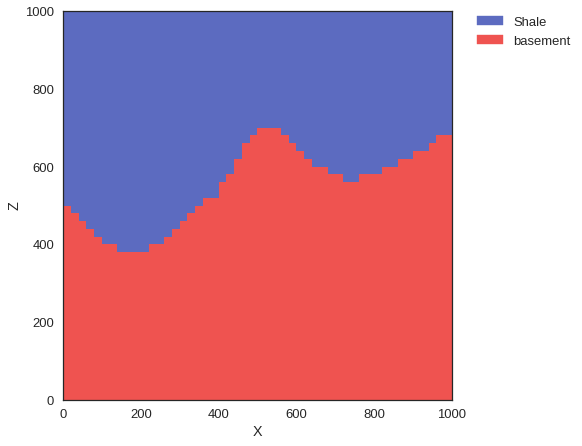

In [7]:
# Plotting sections of our lithology block (lith_sol[0])
gp.plotting.plot_section(geo_data, lith_block, 25, direction='y')

GemPy provides a function to the gradient fields (together with the scalar field). This helps to visualize that the gradients are the normal vectors perpendicular to isosurfaces of the scalar field. Thus, it is also an indicator for the slope of surfaces. The normals are represented by quiver arrows below. The longer the arrow, the larger the magnitude of the gradient/slope at that position. Arrow directions indicate the dip direction of an isosurface.

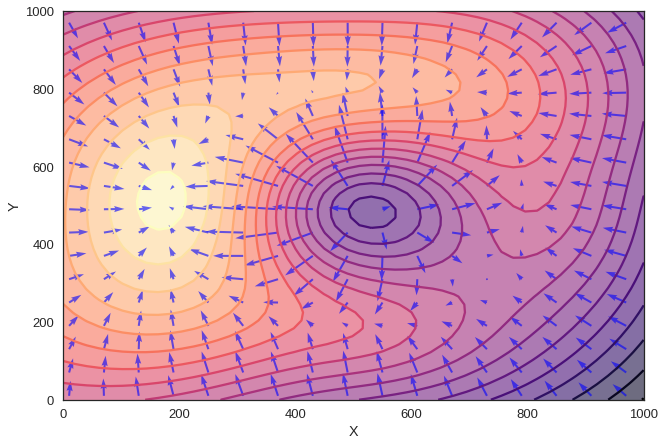

In [8]:
gp.plot_gradient(geo_data, pot_field, GX, GY, GZ, 35, direction='z', quiver_stepsize=3)

The figure above illustrates how certain key topographical features of surfaces can be found via the gradients, in particular GX and GY (seen from a topview in Z-direction). It can be seen that arrows diverge (1) and some points and converge at others (2). To the lower right of central circular divergence structure, it can be seen that the arrows converge in one diagonal direction, but diverge in the perpendicular diagonal direction (3). All of these are points at which the gradients are zero and the arrows eventually disappear in X-Y (the normal vectors point parallel to Z). These are stationary point, of which (1) are maxima, (2) minima and (3) saddle points.

The functions in `spill_analysis` aim to:
1. detect such stationary points 
    by finding points where two gradient fields (mostly GX and GY) are zero
2. classify these stationary points into maxima, minima and saddle points 
    by looking at the nature of sign changes in the gradient fields at such points 
    
### The most important `spill_analysis` functions
At the moment, we regard the following to be the most important and useful function of this utility:
1. `plot_surface_extrema` - to create a plot that immediately illstrates the 3D surface of interest and marks all detected minima, maxima and saddle points. Their 3D coordinates are returned by `get_surface_extrema`.
3. `get_highest_max` - returns the 3D coordinates for the highest maximum of given surface
3. `get_highest_saddle_point` - returns the 3D coordinates for the highest saddle point of given surface

(Some more functions useful functions might be added in the future.)

### 1. Plotting detected extrema and saddle points (`plot_surface_extrema`)
For this function, we not only require `geo_data`, GX and GY, but also the vertices for the layer interface of interest. Remember that GemPy refers to lower boundaries of lithologies, not the top. So, to get the basement-shale boundary, we need to pass the shale formation number:

In [9]:
# Getting the number of the sealing shale formation to attain the relevant surface vertices
seal_n = geo_data.formations.loc['Shale','formation_number']
seal_surf_v, seal_surf_s = gp.get_surfaces(interp_data, pot_field, potential_fault=None, n_formation = seal_n)

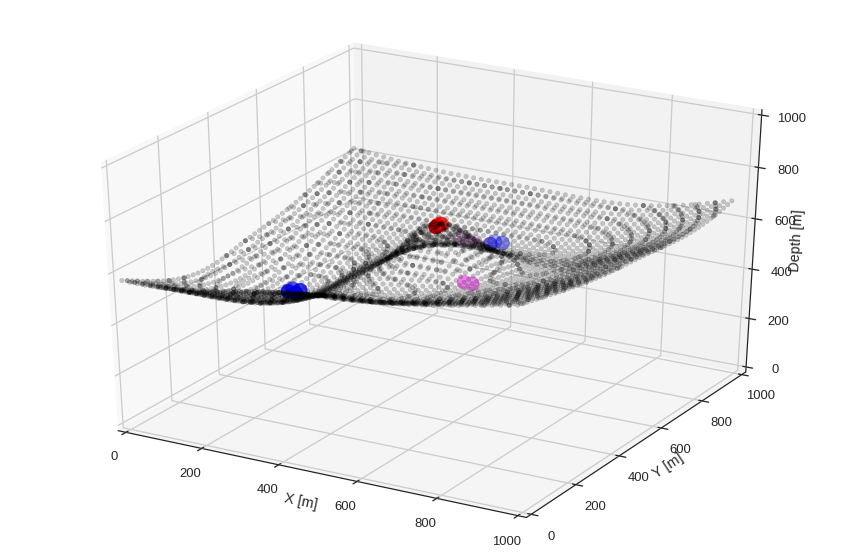

In [10]:
# For a better view in 3D, we can also use `%matplotlib notebook` 
# (cell might have to be executed several times until it works properly)
%matplotlib inline
figsize(15,10)
sp.plot_surface_extrema(geo_data, seal_surf_v, GX, GY)

The plot marks detected maxima in red, minima in blue, and saddle points in violet. We can now see that the central dome structure can be clearly associated with one maximum and a decisive saddle points, that indicates the maximum trap fill level.

In [11]:
sp.get_surface_extrema(geo_data, seal_surf_v, GX, GY)

(array([[ 160.        ,  420.        ,  363.16360474],
        [ 160.        ,  440.        ,  363.318367  ],
        [ 180.        ,  420.        ,  363.55175018],
        [ 180.        ,  440.        ,  363.26053619],
        [ 500.        ,  740.        ,  490.13870239],
        [ 500.        ,  760.        ,  490.496521  ],
        [ 520.        ,  760.        ,  490.58109283]]),
 array([[ 520.        ,  460.        ,  699.2640686 ],
        [ 520.        ,  468.04347992,  700.        ],
        [ 514.66018677,  480.        ,  700.        ],
        [ 520.        ,  480.        ,  700.92750549],
        [ 520.        ,  483.04710388,  700.        ],
        [ 524.7826004 ,  480.        ,  700.        ]]),
 array([[ 420.        ,  740.        ,  490.67340851],
        [ 440.        ,  740.        ,  490.76381683],
        [ 460.        ,  740.        ,  490.56480408],
        [ 660.        ,  340.        ,  585.688591  ],
        [ 680.        ,  340.        ,  585.50170898]]))

The plot and the output of the function above show that it is more of an area that is found for each stationary point. We attain several points that are close to the real one. In the future, we plan to implement a function that simply returns one single point which is the mean of points that belong together.

Alternatively, we can assume that for one structure, the highest (in Z) point should be decisive:

### 2. Getting the highest maximum and 3. the highest saddle point

In [12]:
print(sp.get_highest_max(geo_data, seal_surf_v, GX, GY))

[ 520.          480.          700.92750549]


This function returns the coordinates for the highest maimum in the whole model. This is a correct and straight-forward method if you only have one structure of interest in a model, but is not suitable to be used on several potential traps at once. 

The same applies to the use of the highest saddle point:

In [13]:
print(sp.get_highest_saddle_point(geo_data, seal_surf_v, GX, GY))

[ 660.        340.        585.688591]


However, if we can confirm that these are the points relevant for the structure we want to examine, these give us some simple but valuable information. The difference in depth (Z-position) equals the maximum column height of our trap, assuming perfect sealing (in reality, sealing capacity of the cap rock is an important additional factor). Working with GemPy's lithology block and the shape of the seal surface, we can furthermore derive the volume of the trap knowing these two points.

## Example II: Faulted anticlinal trap
This next synthetic model comprises several lithological units in one series, presenting anticlinal deformation and normal faulting. A trap could be defined by seal dipping on one side and by the fault, i.e. juxtaposition with a sealing unit, on the other side.

We construct the model as usual and include additional lithologies, as well as the fault.

In [14]:
# Importing the data from CSV-files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[50,50,50],
                         path_o = os.pardir+"/input_data/NormalFault_AnticlinalTrap_O.csv",
                         path_i = os.pardir+"/input_data/NormalFault_AnticlinalTrap_P.csv")

# Define that we have one fault in our model
geo_data.n_faults = 1

# Assigning series to formations and orders 
gp.set_series(geo_data, {"fault":'NormalFault', 
                      "Rest":('Overlying', 'Sandstone2', 'Shale', 'Sandstone')},
                       order_series = ["fault","Rest",], order_formations=['NormalFault', 
                                         'Overlying', 'Sandstone2', 'Shale', 'Sandstone',
                                         ])

In [15]:
# INTERPOLATION
interp_data = gp.InterpolatorData(geo_data, u_grade = [1, 1], output='gradients', dtype ='float64',
                                 compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1


In [16]:
# COMPUTATION OF THE MODEL (note that this time there is a fault solution!)
lith_sol, fault_sol = gp.compute_model(interp_data)

In [17]:
lith_block = lith_sol[0] # lithology block
pot_field  = lith_sol[1] # potential field 
GX         = lith_sol[2] # gradient field in X-direction
GY         = lith_sol[3] # gradient field in Y-direction
GZ         = lith_sol[4] # gradient field in Z-direction

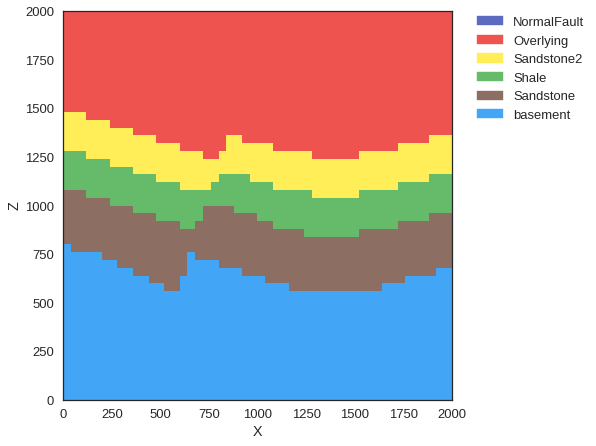

In [18]:
# Plotting sections of our lithology block (lith_sol[0])
gp.plotting.plot_section(geo_data, lith_block, 25, direction='y')

### Important note regarding gradients and faults!
If we take a closer look a the gradient plot below, in particular in directions Y and Z, we can see that, while the fault presence affects the scalar field of the lithology, it does not have any influence on the gradient fields of the lithology. Magnitudes stay constant and arrows keep pointing in the same direction. The calculation of gradients is implemented in GemPy in a way that they stay constant across faults.

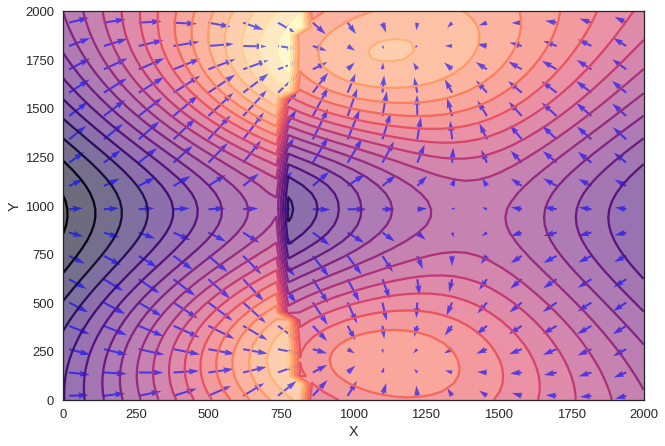

In [19]:
gp.plot_gradient(geo_data, pot_field, GX, GY, GZ, 25, direction='z', quiver_stepsize=3)

That the gradient field is undisturbed by fault presences also means that certain structural features caused faulting cannot be detected via gradient-based approaches. This can be seen below, where we call the `plot_surface_extrema` function. Two minima and a decisive saddle point are found for the shale surface. However, a maximum caused by fault throw is ignored by the function. 
This is, in fact, desirable. It makes sense to examine the influence of faults separately and consider that the lithological interface might be disturbed in its continuity.

Fault-related effects and features are the focus of a different GemPy utility module called `fault_analysis`. Its functions allow not only for the recognition of this maximum contact of the shale boundary with the fault, but also return juxtaposition situations, fault throw and more.

In [20]:
# Getting the number of the sealing shale formation to attain the relevant surface vertices
seal_n = geo_data.formations.loc['Shale','formation_number']
seal_surf_v, seal_surf_s = gp.get_surfaces(interp_data, pot_field, potential_fault=None, n_formation = seal_n)

No maxima found for surface.


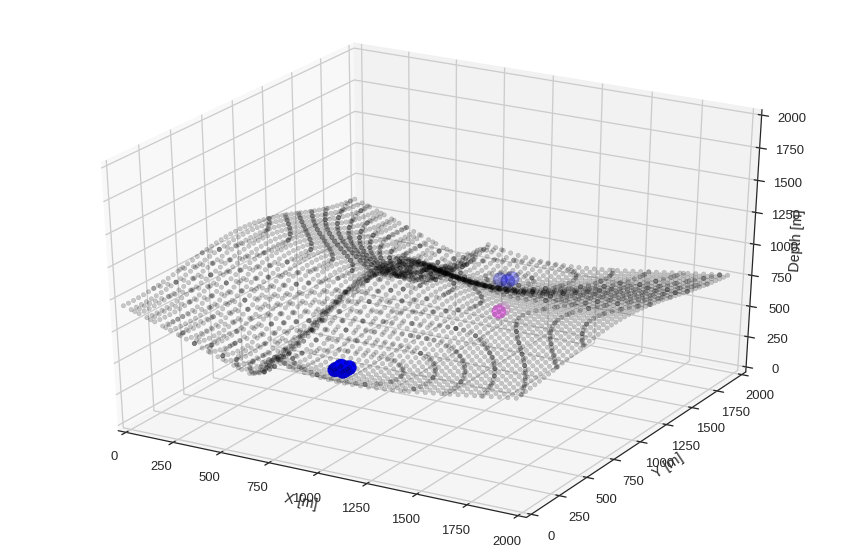

In [21]:
# For a better view in 3D, we can also use `%matplotlib notebook` 
# (cell might have to be executed several times until it works properly)
%matplotlib inline
figsize(15,10)
sp.plot_surface_extrema(geo_data, seal_surf_v, GX, GY)

## Limitations and planned future implementations
The current state of this module allows for a reliable detection of key topographical features. However, considering the possible use in automatized analyses and calculations, for example to attain the maximum trap volume in a model, we would have to be sure that there is only one target structure per lithological interface. In the case of several possible structures or even a completely unknown situation, it might still be necessary to assign detected extrema and saddle points to their respective structure.

A useful extension to this module might thus be the automatic scale-dependant recognition of complete structures  and subsequent classification detected points. Each dome structure would have exactly one maximum and one saddle point. We plan to developa function that returns a list with structures and their assigned gradient stationary points. It should also be possible to implement respective visualizations.